In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
# Input image
image = cv2.imread('image.jpg')
image = cv2.resize(image, (720, 640))

In [6]:
# Load pre-trained models for face, age and gender detection
face = cv2.dnn.readNet("opencv_face_detector_uint8.pb", "opencv_face_detector.pbtxt")

age = cv2.dnn.readNet("age_net.caffemodel", "age_deploy.prototxt")

gen = cv2.dnn.readNet("gender_net.caffemodel", "gender_deploy.prototxt")

In [7]:
# Categories of distribution
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
la = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
      '(25-32)', '(38-43)', '(48-53)', '(60-100)']
lg = ['Male', 'Female']

In [8]:
# Copy image
fr_cv = image.copy()

In [9]:
# Face detection
fr_h = fr_cv.shape[0]
fr_w = fr_cv.shape[1]
blob = cv2.dnn.blobFromImage(fr_cv, 1.0, (300, 300),
                             [104, 117, 123], True, False)

face.setInput(blob)
detections = face.forward()

In [10]:
# Face bounding box creation
faceBoxes = []
for i in range(detections.shape[2]):
    
    #Bounding box creation if confidence > 0.7
    confidence = detections[0, 0, i, 2]
    if confidence > 0.7:
        
        x1 = int(detections[0, 0, i, 3]*fr_w)
        y1 = int(detections[0, 0, i, 4]*fr_h)
        x2 = int(detections[0, 0, i, 5]*fr_w)
        y2 = int(detections[0, 0, i, 6]*fr_h)
        
        faceBoxes.append([x1, y1, x2, y2])
        
        cv2.rectangle(fr_cv, (x1, y1), (x2, y2),
                      (0, 255, 0), int(round(fr_h/150)), 8)
        
faceBoxes

[[369, 143, 506, 362]]

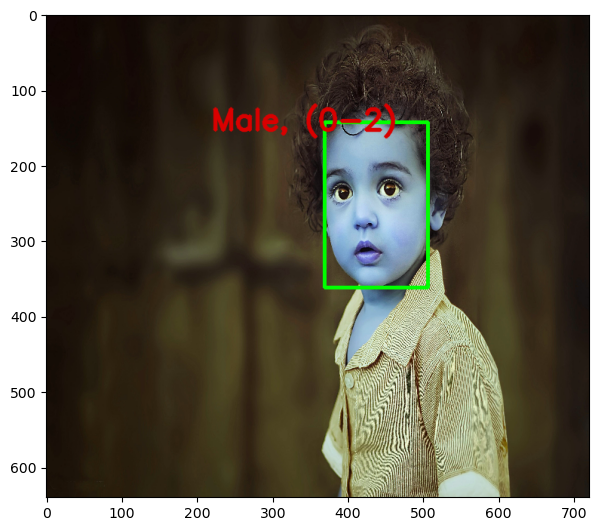

In [11]:
# Checking if face detected or not
if not faceBoxes:
    print("No face detected")

# Final results (otherwise)
# Loop for all the faces detected
for faceBox in faceBoxes:
    
    #Extracting face as per the faceBox
    face = fr_cv[max(0, faceBox[1]-15):
                 min(faceBox[3]+15, fr_cv.shape[0]-1),
                 max(0, faceBox[0]-15):min(faceBox[2]+15,
                               fr_cv.shape[1]-1)]
    
    #Extracting the main blob part
    blob = cv2.dnn.blobFromImage(
        face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    
    #Prediction of gender
    gen.setInput(blob)
    genderPreds = gen.forward()
    gender = lg[genderPreds[0].argmax()]
    
    #Prediction of age
    age.setInput(blob)
    agePreds = age.forward()
    age = la[agePreds[0].argmax()]
    
    #Putting text of age and gender 
    #At the top of box
    cv2.putText(fr_cv,
                f'{gender}, {age}',
                (faceBox[0]-150, faceBox[1]+10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.3,
                (217, 0, 0),
                4,
                cv2.LINE_AA)

    plt.figure(figsize=(7, 7))
    plt.imshow(fr_cv)

In [12]:
import cv2
import numpy as np

# Load the pre-trained models
face_proto = "opencv_face_detector.pbtxt"
face_model = "opencv_face_detector_uint8.pb"
age_proto = "age_deploy.prototxt"
age_model = "age_net.caffemodel"
gender_proto = "gender_deploy.prototxt"
gender_model = "gender_net.caffemodel"

# Load networks
face_net = cv2.dnn.readNet(face_model, face_proto)
age_net = cv2.dnn.readNet(age_model, age_proto)
gender_net = cv2.dnn.readNet(gender_model, gender_proto)

# Define mean values, age list, and gender list
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
AGE_LIST = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
GENDER_LIST = ['Male', 'Female']

def detect_faces(net, frame, conf_threshold=0.7):
    """Detect faces in a given frame."""
    frame_height, frame_width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_height)
            bboxes.append([x1, y1, x2, y2])
    return bboxes

def predict_age(net, face):
    """Predict age of the detected face."""
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    net.setInput(blob)
    predictions = net.forward()
    age_index = predictions[0].argmax()
    return AGE_LIST[age_index]

def predict_gender(net, face):
    """Predict gender of the detected face."""
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    net.setInput(blob)
    predictions = net.forward()
    gender_index = predictions[0].argmax()
    return GENDER_LIST[gender_index]

# Open the camera feed
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    # Detect faces
    bboxes = detect_faces(face_net, frame)

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        face = frame[y1:y2, x1:x2]
        if face.size == 0:
            continue

        # Predict age and gender
        age = predict_age(age_net, face)
        gender = predict_gender(gender_net, face)

        # Draw bounding box and label
        label = f"{gender}, {age}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow("Age and Gender Detection", frame)

    # Break on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()